# Lab | Unsupervised learning intro

### Instructions

It's the moment to perform clustering on the songs you collected. Remember that the ultimate goal of this little project is to improve the recommendations of artists. Clustering the songs will allow the recommendation system to limit the scope of the recommendations to only songs that belong to the same cluster - songs with similar audio features.

The experiments you did with the Spotify API and the Billboard web scraping will allow you to create a pipeline such that when the user enters a song, you:

Check whether or not the song is in the Billboard Hot 200.
Collect the audio features from the Spotify API.
After that, you want to send the Spotify audio features of the submitted song to the clustering model, which should return a cluster number.

We want to have as many songs as possible to create the clustering model, so we will add the songs you collected to a bigger dataset available on Kaggle containing 160 thousand songs.

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from time import sleep
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min

In [2]:
# Lab 3 start

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

secrets_file = open("secrets.txt","r")
password = secrets_file.read()
password = password.replace(" ", "")


secrets_dict={}
for line in password.split('\n'):
    if len(line) > 0:
        secrets_dict[line.split(':')[0]]=line.split(':')[1]

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['ClientID'], client_secret=secrets_dict['ClientSecret']))

In [3]:
sp_list = pd.read_csv("spotify_tracks.csv",encoding='latin-1')
hot_100 = pd.read_csv("Hot_100.csv",encoding='latin-1')
scraped_songs = pd.read_csv("500_songs.csv",encoding='latin-1')

In [4]:
X1= sp_list[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
                                 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']]

scaler = StandardScaler()
X = scaler.fit_transform(X1)
X = pd.DataFrame(X, columns=X1.columns)

In [5]:
X.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,-2.256451,-1.644367,0.493130,-0.867538,0.86686,-0.700966,2.185984,2.017044,-0.820618,-1.914174,-0.641817,1.487040,-3.324045
1,-3.031265,-0.181306,0.769551,-0.432043,0.86686,-0.508343,2.491900,-0.185699,-0.828612,-0.159485,2.168638,1.862158,-3.324045
2,-2.043377,0.533544,-1.441816,0.029027,0.86686,-0.658161,-0.201649,4.250629,-0.794456,-0.745777,-0.709183,-0.244658,-3.324045
3,-0.086973,-1.534757,-0.888974,-1.444301,0.86686,-0.606795,1.846493,0.514722,-0.727597,0.075032,-1.517053,0.391548,0.134398
4,-0.997379,0.500185,-1.165395,0.429449,0.86686,-0.663511,-0.720586,-0.269670,0.108143,-0.427504,0.370801,0.805140,0.134398


Text(0.5, 1.0, 'Elbow Method showing the optimal k within 2-19')

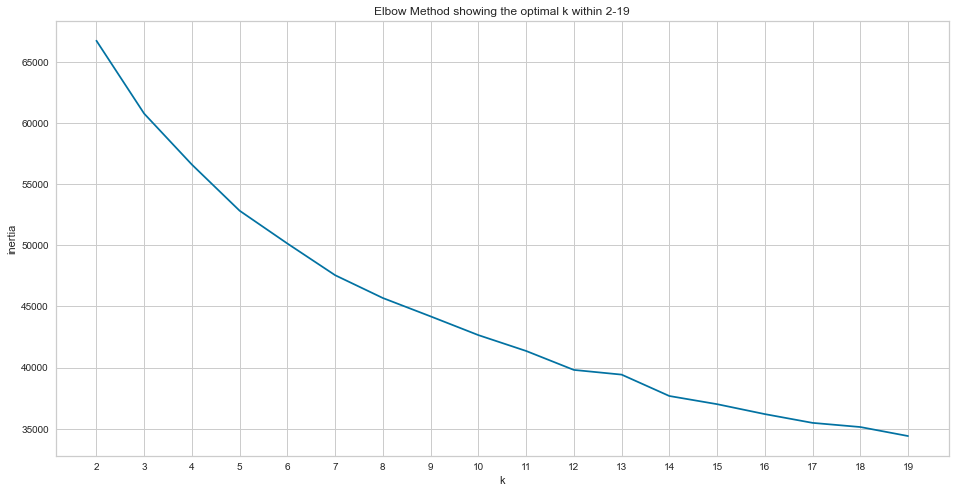

In [6]:
K = range(2,20)
inertias = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=42,
                   )
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    

plt.figure(figsize=(16,8))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title(f'Elbow Method showing the optimal k within 2-19')

  0%|          | 0/18 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Silhouette Method showing the optimal k within 2-19 range')

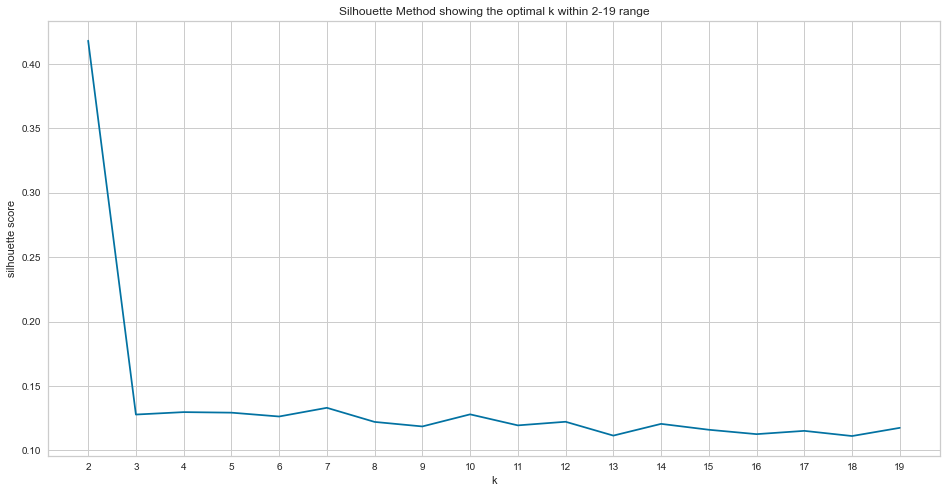

In [7]:
K = range(2,20)
silhouettes = []

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    silhouettes.append(silhouette_score(X, kmeans.predict(X) )
                   )

plt.figure(figsize=(16,8))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title(f'Silhouette Method showing the optimal k within 2-19 range')

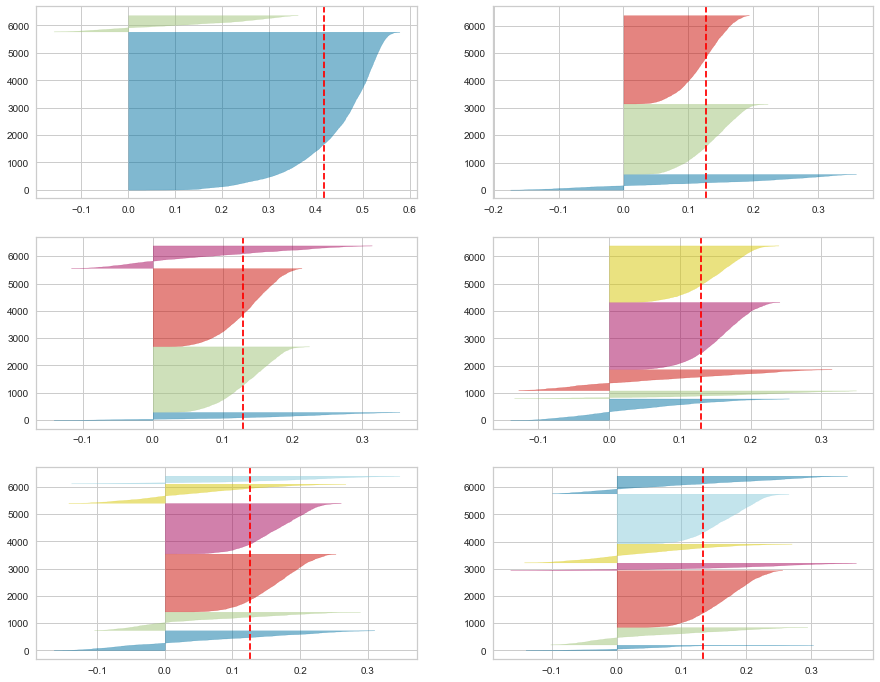

In [8]:
fig, ax = plt.subplots(3, 2, figsize=(15,12))
for k in [2, 3, 4, 5, 6, 7]:

    km = KMeans(n_clusters=k,
                random_state=42)
    q, mod = divmod(k, 2)
 
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)

In [9]:
cols = X.columns

In [10]:
kmeans = KMeans(n_clusters=6,
               random_state=42)
kmeans.fit(X)

clusters = kmeans.predict(X)

In [11]:
clusters.shape

(6356,)

In [12]:
songs_clustered = X.copy()
songs_clustered['cluster_id'] = clusters

In [13]:
songs_clustered.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster_id
0,-2.256451,-1.644367,0.493130,-0.867538,0.86686,-0.700966,2.185984,2.017044,-0.820618,-1.914174,-0.641817,1.487040,-3.324045,5
1,-3.031265,-0.181306,0.769551,-0.432043,0.86686,-0.508343,2.491900,-0.185699,-0.828612,-0.159485,2.168638,1.862158,-3.324045,0
2,-2.043377,0.533544,-1.441816,0.029027,0.86686,-0.658161,-0.201649,4.250629,-0.794456,-0.745777,-0.709183,-0.244658,-3.324045,0
3,-0.086973,-1.534757,-0.888974,-1.444301,0.86686,-0.606795,1.846493,0.514722,-0.727597,0.075032,-1.517053,0.391548,0.134398,0
4,-0.997379,0.500185,-1.165395,0.429449,0.86686,-0.663511,-0.720586,-0.269670,0.108143,-0.427504,0.370801,0.805140,0.134398,2


In [14]:
cluster_centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=cols)
cluster_centers_df['cluster_id'] = range(0,6)

In [15]:
pca = PCA(2) 
X_2D = pca.fit_transform(X)
X_2D

array([[ 5.20603167e+00, -1.13073587e+00],
       [ 3.21777794e+00, -2.52249148e+00],
       [ 2.78426908e+00, -1.93347705e+00],
       ...,
       [-8.00045789e-01,  2.72748745e+00],
       [-5.34157909e-01,  2.10319969e+00],
       [-2.42247766e-03,  9.28779359e-01]])

In [16]:
kmeans2 = KMeans(n_clusters=6, random_state=42)
kmeans2.fit(X_2D)

KMeans(n_clusters=6, random_state=42)

In [17]:
clusters = kmeans2.predict(X_2D)
clusters

array([4, 0, 0, ..., 3, 3, 3])

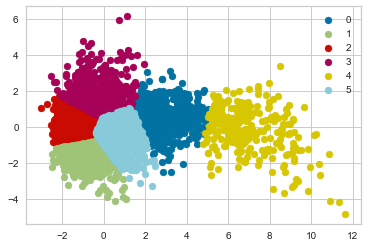

In [18]:
labels = np.unique(clusters)

for i in labels:
    plt.scatter(X_2D[clusters == i , 0] , X_2D[clusters == i , 1] , label = i)
plt.legend()
plt.show()